In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import scipy.stats as stats
import time

In [ ]:
# Load and preprocess the diabetes dataset
def load_diabetes_data():
    diabetes = load_diabetes()
    X = diabetes.data
    y = diabetes.target
    
    # Standardize features and target
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Generate simulated posterior samples (in a real implementation, these would come from MCMC)
def generate_posterior_samples(X_train, y_train, n_samples=1000, c=1.0):
    n, d = X_train.shape
    
    # Fit initial linear regression model
    beta_hat = np.linalg.lstsq(np.column_stack([np.ones(n), X_train]), y_train, rcond=None)[0]
    beta0_hat, beta_hat = beta_hat[0], beta_hat[1:]
    
    # Compute residual standard deviation
    y_pred = beta0_hat + X_train @ beta_hat
    residuals = y_train - y_pred
    sigma_hat = np.std(residuals) * c  # Apply prior specification parameter
    
    # Generate posterior samples
    posterior_samples = {
        'coefficients': np.random.normal(beta_hat, 0.1, size=(n_samples, d)),
        'intercept': np.random.normal(beta0_hat, 0.1, size=n_samples),
        'sigma': np.random.gamma(shape=10, scale=sigma_hat/10, size=n_samples)
    }
    
    return posterior_samples

In [ ]:
# Bayesian credible interval
def compute_bayesian_interval(X_train, y_train, x_test, posterior_samples, alpha=0.2):
    y_preds = []
    
    # Make predictions using each posterior sample
    for i in range(len(posterior_samples['coefficients'])):
        beta = posterior_samples['coefficients'][i]
        beta0 = posterior_samples['intercept'][i]
        y_pred = beta0 + x_test @ beta
        y_preds.append(y_pred)
    
    # Compute credible interval from posterior predictive distribution
    lower = np.percentile(y_preds, 100 * alpha/2)
    upper = np.percentile(y_preds, 100 * (1 - alpha/2))
    
    return lower, upper

In [ ]:
# Split conformal prediction
def compute_split_conformal_interval(X_train, y_train, x_test, alpha=0.2):
    # Split training data into proper training and calibration sets
    X_proper, X_calib, y_proper, y_calib = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)
    
    # Fit model on proper training set (using Lasso as in the paper)
    model = Lasso(alpha=0.01)
    model.fit(X_proper, y_proper)
    
    # Generate predictions on calibration set
    y_pred_calib = model.predict(X_calib)
    
    # Calculate residuals
    residuals = np.abs(y_calib - y_pred_calib)
    
    # Calculate quantile of residuals
    q = np.quantile(residuals, 1 - alpha)
    
    # Generate prediction for test point
    y_pred_test = model.predict([x_test])[0]
    
    # Return prediction interval
    return y_pred_test - q, y_pred_test + q

In [ ]:
# Simplified conformal Bayesian prediction (without full JAX implementation)
def compute_conformal_bayes_interval(X_train, y_train, x_test, posterior_samples, alpha=0.2):
    n = len(y_train)
    n_samples = len(posterior_samples['coefficients'])
    
    # Create grid of y values
    y_min, y_max = np.min(y_train) - 2, np.max(y_train) + 2
    y_grid = np.linspace(y_min, y_max, 100)
    
    # Pre-compute log predictive densities for training points
    log_p_train = np.zeros((n_samples, n))
    for i in range(n):
        for t in range(n_samples):
            beta = posterior_samples['coefficients'][t]
            beta0 = posterior_samples['intercept'][t]
            sigma = posterior_samples['sigma'][t]
            
            # Compute mean and log density
            mu = beta0 + X_train[i] @ beta
            log_p_train[t, i] = -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((y_train[i] - mu) / sigma)**2
    
    # For each y in the grid, determine if it's in the conformal set
    in_conformal_set = []
    
    for y_candidate in y_grid:
        # Compute log importance weights
        log_weights = np.zeros(n_samples)
        for t in range(n_samples):
            beta = posterior_samples['coefficients'][t]
            beta0 = posterior_samples['intercept'][t]
            sigma = posterior_samples['sigma'][t]
            
            # Compute mean and log density
            mu = beta0 + x_test @ beta
            log_weights[t] = -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((y_candidate - mu) / sigma)**2
        
        # Reshape for the expected input format
        log_weights_reshaped = log_weights.reshape(1, -1)
        
        # Compute rank of the test point's conformity score
        wjk = np.exp(log_weights_reshaped)
        Zjk = np.sum(wjk, axis=1).reshape(-1, 1)
        
        # Compute predictives
        p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
        p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk
        
        # Compute rank
        pred_tot = np.concatenate((p_cp, p_new), axis=1)
        rank = np.sum(pred_tot <= pred_tot[:, -1].reshape(-1, 1), axis=1)[0]
        
        # Check if y_candidate is in the conformal set
        in_conformal_set.append(rank > alpha * (n + 1))
    
    # Find the bounds of the conformal set
    in_conformal_set = np.array(in_conformal_set)
    if np.any(in_conformal_set):
        indices = np.where(in_conformal_set)[0]
        lower = y_grid[indices[0]]
        upper = y_grid[indices[-1]]
        return lower, upper
    else:
        # If no points in conformal set, return empty interval
        return None, None

Training data shape: (309, 10), Test data shape: (133, 10)

Testing with c = 1.0 (prior specification parameter)
  Test point 1/5, true value: 0.0762
    Bayes:  [-1.6618, -0.6579]  (width: 1.0039)
    Split:  [-1.8929, -0.1152]  (width: 1.7777)
    CB:     [-2.4133, 0.0620]  (width: 2.4753)


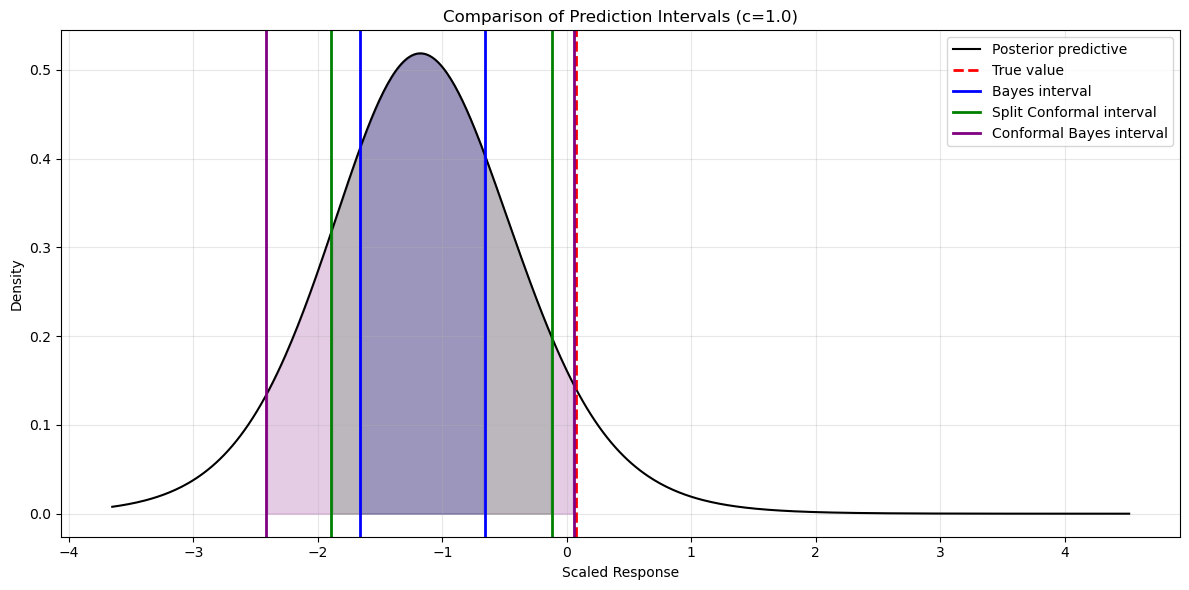

  Test point 2/5, true value: 0.6476
    Bayes:  [-0.4549, 0.2387]  (width: 0.6936)
    Split:  [-0.9667, 0.8111]  (width: 1.7777)
    CB:     [-1.0931, 0.8871]  (width: 1.9802)
  Test point 3/5, true value: -0.5082
    Bayes:  [-1.2118, -0.3855]  (width: 0.8263)
    Split:  [-1.5011, 0.2767]  (width: 1.7777)
    CB:     [-1.9182, 0.3095]  (width: 2.2278)
  Test point 4/5, true value: 0.0502
    Bayes:  [-0.2132, 0.5452]  (width: 0.7583)
    Split:  [-0.8069, 0.9708]  (width: 1.7777)
    CB:     [-0.8456, 1.2171]  (width: 2.0628)
  Test point 5/5, true value: -1.1964
    Bayes:  [-0.5401, 0.0718]  (width: 0.6119)
    Split:  [-1.0985, 0.6792]  (width: 1.7777)
    CB:     [-1.1757, 0.7221]  (width: 1.8977)

Testing with c = 0.02 (prior specification parameter)
  Test point 1/5, true value: 0.0762


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


    Bayes:  [-1.6525, -0.6874]  (width: 0.9651)
    Split:  [-1.8929, -0.1152]  (width: 1.7777)
    CB:     [-2.6608, 0.4746]  (width: 3.1354)


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


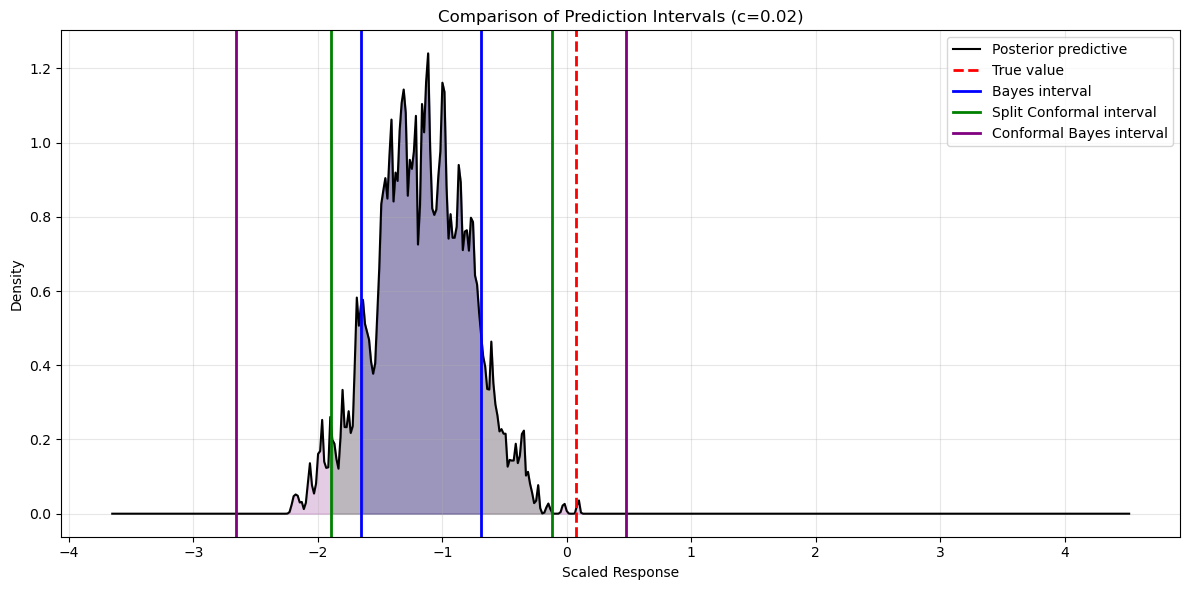

  Test point 2/5, true value: 0.6476


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


    Bayes:  [-0.4690, 0.2288]  (width: 0.6978)
    Split:  [-0.9667, 0.8111]  (width: 1.7777)
    CB:     [-1.8357, 1.2997]  (width: 3.1354)
  Test point 3/5, true value: -0.5082


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


    Bayes:  [-1.2129, -0.3991]  (width: 0.8138)
    Split:  [-1.5011, 0.2767]  (width: 1.7777)
    CB:     [-2.1658, 0.9696]  (width: 3.1354)
  Test point 4/5, true value: 0.0502


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


    Bayes:  [-0.1736, 0.6051]  (width: 0.7787)
    Split:  [-0.8069, 0.9708]  (width: 1.7777)
    CB:     [-1.3407, 1.5472]  (width: 2.8879)
  Test point 5/5, true value: -1.1964


/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:135: RuntimeWarning: invalid value encountered in true_divide
  p_cp = np.dot(wjk/Zjk, np.exp(log_p_train))
/var/folders/jd/6r53hnhd1010dvv7t8wc731h0000gp/T/ipykernel_89965/1207039033.py:136: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.sum(wjk**2, axis=1).reshape(-1, 1)/Zjk


    Bayes:  [-0.5249, 0.0883]  (width: 0.6132)
    Split:  [-1.0985, 0.6792]  (width: 1.7777)
    CB:     [-1.5057, 0.8871]  (width: 2.3928)

RESULTS SUMMARY

c=1.0:

Coverage:
  Bayes:  40.00%
  Split:  60.00%
  CB:     60.00%

Average Interval Length:
  Bayes:  0.7788
  Split:  1.7777
  CB:     2.1288

Average Computation Time (seconds):
  Bayes:  0.0010
  Split:  0.0009
  CB:     0.7798

c=0.02:

Coverage:
  Bayes:  40.00%
  Split:  60.00%
  CB:     100.00%

Average Interval Length:
  Bayes:  0.7737
  Split:  1.7777
  CB:     2.9374

Average Computation Time (seconds):
  Bayes:  0.0009
  Split:  0.0009
  CB:     0.8381



In [ ]:
# Run comparison test
def run_comparison_test(n_test_points=10, c_values=[1.0, 0.02]):
    # Load data
    X_train, X_test, y_train, y_test = load_diabetes_data()
    print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
    
    # Select test points
    test_indices = np.random.choice(len(X_test), n_test_points, replace=False)
    
    results = {}
    
    for c in c_values:
        print(f"\nTesting with c = {c} (prior specification parameter)")
        
        # Generate posterior samples
        posterior_samples = generate_posterior_samples(X_train, y_train, n_samples=1000, c=c)
        
        # Initialize coverage and length tracking
        coverage_bayes = 0
        coverage_split = 0
        coverage_cb = 0
        
        lengths_bayes = []
        lengths_split = []
        lengths_cb = []
        
        times_bayes = []
        times_split = []
        times_cb = []
        
        # Test on each selected test point
        for i, idx in enumerate(test_indices):
            x_test = X_test[idx]
            y_test_val = y_test[idx]
            
            print(f"  Test point {i+1}/{n_test_points}, true value: {y_test_val:.4f}")
            
            # Compute Bayesian interval
            start_time = time.time()
            bayes_lower, bayes_upper = compute_bayesian_interval(
                X_train, y_train, x_test, posterior_samples, alpha=0.2)
            times_bayes.append(time.time() - start_time)
            
            # Compute split conformal interval
            start_time = time.time()
            split_lower, split_upper = compute_split_conformal_interval(
                X_train, y_train, x_test, alpha=0.2)
            times_split.append(time.time() - start_time)
            
            # Compute conformal Bayes interval
            start_time = time.time()
            cb_lower, cb_upper = compute_conformal_bayes_interval(
                X_train, y_train, x_test, posterior_samples, alpha=0.2)
            times_cb.append(time.time() - start_time)
            
            # Check coverage
            if bayes_lower <= y_test_val <= bayes_upper:
                coverage_bayes += 1
            
            if split_lower <= y_test_val <= split_upper:
                coverage_split += 1
            
            if cb_lower is not None and cb_lower <= y_test_val <= cb_upper:
                coverage_cb += 1
            
            # Record interval lengths
            lengths_bayes.append(bayes_upper - bayes_lower)
            lengths_split.append(split_upper - split_lower)
            if cb_lower is not None:
                lengths_cb.append(cb_upper - cb_lower)
            
            # Print intervals
            print(f"    Bayes:  [{bayes_lower:.4f}, {bayes_upper:.4f}]  (width: {bayes_upper-bayes_lower:.4f})")
            print(f"    Split:  [{split_lower:.4f}, {split_upper:.4f}]  (width: {split_upper-split_lower:.4f})")
            if cb_lower is not None:
                print(f"    CB:     [{cb_lower:.4f}, {cb_upper:.4f}]  (width: {cb_upper-cb_lower:.4f})")
            else:
                print("    CB:     None")
            
            # Visualize the first test point
            if i == 0:
                visualize_intervals(X_train, y_train, x_test, y_test_val, posterior_samples, c=c)
        
        # Compute summary statistics
        results[f'c={c}'] = {
            'coverage': {
                'bayes': coverage_bayes / n_test_points,
                'split': coverage_split / n_test_points,
                'cb': coverage_cb / n_test_points
            },
            'avg_length': {
                'bayes': np.mean(lengths_bayes),
                'split': np.mean(lengths_split),
                'cb': np.mean(lengths_cb) if lengths_cb else None
            },
            'avg_time': {
                'bayes': np.mean(times_bayes),
                'split': np.mean(times_split),
                'cb': np.mean(times_cb)
            }
        }
    
    return results

# Visualize intervals for a single test point
def visualize_intervals(X_train, y_train, x_test, y_test, posterior_samples, c=1.0):
    # Compute intervals
    bayes_lower, bayes_upper = compute_bayesian_interval(
        X_train, y_train, x_test, posterior_samples, alpha=0.2)
    
    split_lower, split_upper = compute_split_conformal_interval(
        X_train, y_train, x_test, alpha=0.2)
    
    cb_lower, cb_upper = compute_conformal_bayes_interval(
        X_train, y_train, x_test, posterior_samples, alpha=0.2)
    
    # Generate posterior predictive distribution for visualization
    y_grid = np.linspace(np.min(y_train) - 2, np.max(y_train) + 2, 500)
    densities = np.zeros_like(y_grid)
    
    n_samples = len(posterior_samples['coefficients'])
    for i in range(n_samples):
        beta = posterior_samples['coefficients'][i]
        beta0 = posterior_samples['intercept'][i]
        sigma = posterior_samples['sigma'][i]
        
        mu = beta0 + x_test @ beta
        densities += stats.norm.pdf(y_grid, mu, sigma)
    
    densities /= n_samples
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    plt.plot(y_grid, densities, 'k-', label='Posterior predictive')
    plt.axvline(y_test, color='r', linestyle='--', linewidth=2, label='True value')
    
    plt.axvline(bayes_lower, color='blue', linestyle='-', linewidth=2, label='Bayes interval')
    plt.axvline(bayes_upper, color='blue', linestyle='-', linewidth=2)
    
    plt.axvline(split_lower, color='green', linestyle='-', linewidth=2, label='Split Conformal interval')
    plt.axvline(split_upper, color='green', linestyle='-', linewidth=2)
    
    if cb_lower is not None:
        plt.axvline(cb_lower, color='purple', linestyle='-', linewidth=2, label='Conformal Bayes interval')
        plt.axvline(cb_upper, color='purple', linestyle='-', linewidth=2)
    
    # Shade the intervals
    plt.fill_between(y_grid, 0, densities, where=(y_grid >= bayes_lower) & (y_grid <= bayes_upper), 
                    color='blue', alpha=0.2)
    plt.fill_between(y_grid, 0, densities, where=(y_grid >= split_lower) & (y_grid <= split_upper), 
                    color='green', alpha=0.2)
    
    if cb_lower is not None:
        plt.fill_between(y_grid, 0, densities, where=(y_grid >= cb_lower) & (y_grid <= cb_upper), 
                        color='purple', alpha=0.2)
    
    plt.title(f'Comparison of Prediction Intervals (c={c})')
    plt.xlabel('Scaled Response')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Display results in a format similar to Table 1 in the paper
def display_results(results):
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    
    for c, c_results in results.items():
        print(f"\n{c}:")
        
        print("\nCoverage:")
        print(f"  Bayes:  {c_results['coverage']['bayes']:.2%}")
        print(f"  Split:  {c_results['coverage']['split']:.2%}")
        print(f"  CB:     {c_results['coverage']['cb']:.2%}")
        
        print("\nAverage Interval Length:")
        print(f"  Bayes:  {c_results['avg_length']['bayes']:.4f}")
        print(f"  Split:  {c_results['avg_length']['split']:.4f}")
        if c_results['avg_length']['cb'] is not None:
            print(f"  CB:     {c_results['avg_length']['cb']:.4f}")
        else:
            print("  CB:     N/A")
        
        print("\nAverage Computation Time (seconds):")
        print(f"  Bayes:  {c_results['avg_time']['bayes']:.4f}")
        print(f"  Split:  {c_results['avg_time']['split']:.4f}")
        print(f"  CB:     {c_results['avg_time']['cb']:.4f}")
    
    print("\n" + "="*50)

# Run the test and display results
np.random.seed(42)
results = run_comparison_test(n_test_points=5)
display_results(results)